In [ ]:
!pip3 install -U tensorflow-text
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 5.2 MB/s 
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 5.9 MB 48.9 MB/s 
     |████████████████████████████████| 438 kB 58.7 MB/s 
     |████████████████████████████████| 1.7 MB 74.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninsta

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import keras
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/mumin-small/tweet.pickle', 'rb') as f:
    tweet_df = pd.DataFrame(pickle.load(f))

tweet_df.dropna(inplace=True)

with open('/content/drive/MyDrive/mumin-small/tweet_discusses_claim.pickle', 'rb') as f:
    tweet_discusses_claim_df = pd.DataFrame(pickle.load(f))
    
with open('/content/drive/MyDrive/mumin-small/claim.pickle', 'rb') as f:
    claim_df = pd.DataFrame(pickle.load(f))
    
tweet_claim_df = (tweet_df.merge(tweet_discusses_claim_df, left_index=True, right_on='src')
                          .merge(claim_df, left_on='tgt', right_index=True)
                          .reset_index(drop=True))


In [ ]:
path = '/content/drive/MyDrive/mumin-small'

with open(path+'/reply.pickle', 'rb') as f:
    reply_df = pd.DataFrame(pickle.load(f))


with open(path+'/reply_reply_to_tweet.pickle', 'rb') as f:
    reply_reply_to_tweet_df = pd.DataFrame(pickle.load(f))

In [ ]:
# Split up the data
train = tweet_claim_df.query('train_mask == True')
val = tweet_claim_df.query('val_mask == True')
test = tweet_claim_df.query('test_mask == True')

# Extract the tweet embeddings
X_train = train.text
X_val = val.text
X_test = test.text

# Extract the labels
y_train = train.label
y_val = val.label
y_test = test.label

y_train = np.array([0 if i == 'misinformation' else 1 for i in y_train])
y_val = np.array([0 if i == 'misinformation' else 1 for i in y_val])
y_test = np.array([0 if i == 'misinformation' else 1 for i in y_test])
# Sanity check the dimensions
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3665,), (3665,), (662,), (662,), (563,), (563,))

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 

over = RandomOverSampler(sampling_strategy=0.3) 
under = RandomUnderSampler(sampling_strategy=0.5) 
 
from imblearn.pipeline import Pipeline 
 
steps = [('o', over), ('u', under)] 
pipeline = Pipeline(steps=steps) 

X_resample, y_resample = pipeline.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.reshape(-1, 1))

In [ ]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
def build_embedding_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    return tf.keras.Model(text_input, net)

In [ ]:
embedding_model = build_embedding_model()

In [ ]:
i = 0
mbert_emb = pd.DataFrame(columns = ['tweet_id', 'mbert_emb'])
while i*1000 < len(reply_df):
    data = np.array(embedding_model(reply_df['text'][1000*i:min((1000*i + 1000), len(reply_df))]))
    for j in range(1000*i, min(1000*i + 1000, len(reply_df))):
        mbert_emb.loc[len(mbert_emb)] = [reply_df['tweet_id'][j], data[j-1000*i]]
    i += 1
mbert_emb.to_pickle('/content/drive/MyDrive/DSPJ/multilingual_emb_sml_reply.pkl') 

In [ ]:
mbert_emb = pd.DataFrame(columns = ['tweet_id', 'mbert_emb'])
data = np.array(embedding_model(tweet_df['text'][:1000]))
for i in range(1000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i]]
data = np.array(embedding_model(tweet_df['text'][1000:2000]))
for i in range(1000,2000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-1000]]
data = np.array(embedding_model(tweet_df['text'][2000:3000]))
for i in range(2000,3000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-2000]]
data = np.array(embedding_model(tweet_df['text'][3000:4000]))
for i in range(3000,4000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-3000]]
data = np.array(embedding_model(tweet_df['text'][4000:5000]))
for i in range(4000,5000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-4000]]
data = np.array(embedding_model(tweet_df['text'][5000:6000]))
for i in range(5000,6000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-5000]]
data = np.array(embedding_model(tweet_df['text'][6000:7000]))
for i in range(6000,7000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-6000]]
data = np.array(embedding_model(tweet_df['text'][7000:8000]))
for i in range(7000,8000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-7000]]
data = np.array(embedding_model(tweet_df['text'][8000:9000]))
for i in range(8000,9000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-8000]]
data = np.array(embedding_model(tweet_df['text'][9000:10000]))
for i in range(9000,10000):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-9000]]
data = np.array(embedding_model(tweet_df['text'][10000:]))
for i in range(10000,len(tweet_df)):
  mbert_emb.loc[len(mbert_emb)] = [tweet_df['tweet_id'][i], data[i-10000]]

In [ ]:
mbert_emb.to_pickle('/content/drive/MyDrive/DSPJ/multilingual_emb_med.pkl')  

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [ ]:
from official.nlp import optimization
epochs = 10
steps_per_epoch = X_resample.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps)
                                          #optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_resample,y_resample,epochs=10)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4
Epoch 1/10
95/95 [==============================] - 100s 884ms/step - loss: 0.6592 - accuracy: 0.6434 - precision: 0.3600 - recall: 0.0896
Epoch 2/10
95/95 [==============================] - 87s 915ms/step - loss: 0.6085 - accuracy: 0.6790 - precision: 0.7126 - recall: 0.0618
Epoch 3/10
95/95 [==============================] - 87s 915ms/step - loss: 0.4913 - accuracy: 0.7686 - precision: 0.7580 - recall: 0.4492
Epoch 4/10
95/95 [==============================] - 87s 915ms/step - loss: 0.3526 - accuracy: 0.8569 - precision: 0.8237 - recall: 0.7261
Epoch 5/10
95/95 [==============================] - 87s 915ms/step - loss: 0.2236 - accuracy: 0.9197 - precision: 0.8936 - recall: 0.8616
Epoch 6/10
95/95 [==============================] - 87s 917ms/step - loss: 0.1196 - accuracy: 0.9588 - precision: 0.9356 - recall: 0.9412
Epoch 7/10
95/95 [==============================] - 87s 915ms/step - loss: 0.0654 - acc

In [ ]:
loss, accuracy, precision, recall = classifier_model.evaluate(X_test,y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')

53/53 [==============================] - 10s 195ms/step - loss: 0.6014 - accuracy: 0.9017 - precision: 0.0926 - recall: 0.1316
Loss: 0.6014384031295776
Accuracy: 0.9016786813735962
precision: 0.09259258955717087
recall: 0.1315789520740509


In [ ]:
from sklearn.metrics import f1_score
# Get predictions
train_preds = classifier_model.predict(X_train)
val_preds = classifier_model.predict(X_val)
test_preds = classifier_model.predict(X_test)

# Compute macro-average F1-score

train_preds = np.array([1 if i>=0.5 else 0 for i in train_preds])
val_preds = np.array([1 if i>=0.5 else 0 for i in val_preds])
test_preds = np.array([1 if i>=0.5 else 0 for i in test_preds])


train_scores = f1_score(y_train, train_preds, average=None)
val_scores = f1_score(y_val, val_preds, average=None)
test_scores = f1_score(y_test, test_preds, average=None)

print('*** Training scores ***')
print(f'Misinformation F1: {100 * train_scores[1]:.2f}%')
print(f'Factual F1: {100 * train_scores[0]:.2f}%')
print(f'Macro-average F1: {100 * train_scores.mean():.2f}%\n')

print('*** Validation scores ***')
print(f'Misinformation F1: {100 * val_scores[1]:.2f}%')
print(f'Factual F1: {100 * val_scores[0]:.2f}%')
print(f'Macro-average F1: {100 * val_scores.mean():.2f}%\n')

print('*** Test scores ***')
print(f'Misinformation F1: {100 * test_scores[1]:.2f}%')
print(f'Factual F1: {100 * test_scores[0]:.2f}%')
print(f'Macro-average F1: {100 * test_scores.mean():.2f}%')

18/18 [==============================] - 6s 323ms/step
*** Training scores ***
Misinformation F1: 87.78%
Factual F1: 98.67%
Macro-average F1: 93.22%

*** Validation scores ***
Misinformation F1: 3.87%
Factual F1: 87.25%
Macro-average F1: 45.56%

*** Test scores ***
Misinformation F1: 25.88%
Factual F1: 93.95%
Macro-average F1: 59.92%


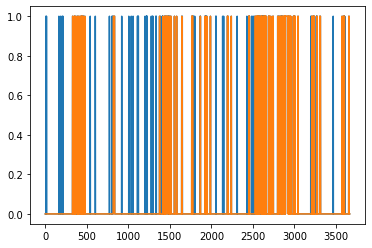

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_preds)
plt.plot(y_train)

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


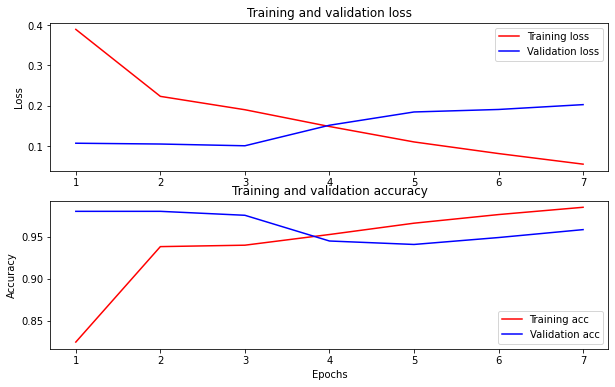

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')